In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Read the csv file**

In [3]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


**Find number of columns and rows**

In [4]:
df.shape

(1599, 12)

It means there are 1599 rows and 12 columns

**Now plot graph to see it's distribution and property**

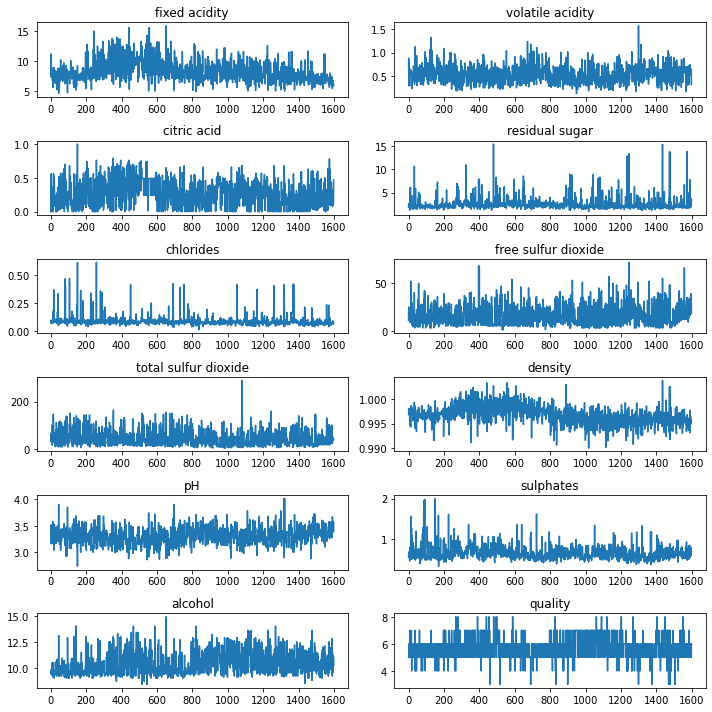

In [5]:
import matplotlib.pyplot as plt
def plot_figure(index,column):
    plt.subplot(6,2,index)
    plt.title(column)
    plt.plot(df[column])
    
plt.figure(figsize=(10,10))

for index , column in enumerate(df.columns):
    if index+1<=len(df.columns):
        plot_figure(index+1, column)

plt.tight_layout()

**Check datatypes of dataframe's columns**

In [6]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

**Checking if there is any missing value exists**

In [7]:
df.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

**As every column name returned false it means that there is not any null value.**

**check correlation between features**

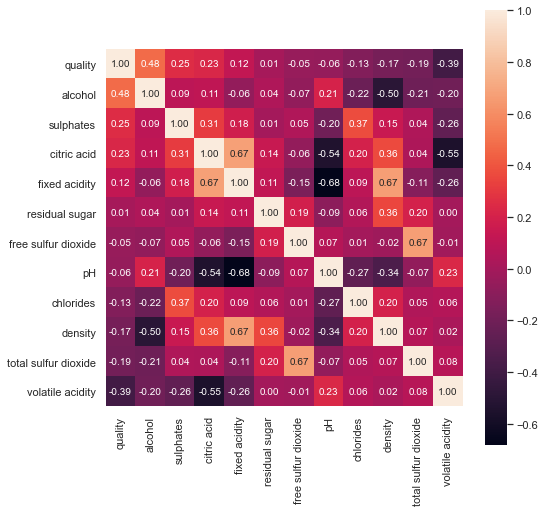

In [8]:
import seaborn as sns
#correlation matrix
corrmat = df.corr()
k = 12 #number of variables for heatmap
cols = corrmat.nlargest(k, 'quality')['quality'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1)
plt.figure(figsize=(8,8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

I have considered highly correlated if correaltion value is >0.7 

In [9]:
input_cols = list(df.columns)[:-1]
input_cols

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [10]:
output_cols = ['quality']

**Convert dataframe to numpy arrays**

In [11]:
def dataframe_to_arrays(df):
    # Make a copy of the original dataframe
    df1 = df.copy(deep=True)
    # Extract input & outupts as numpy arrays
    inputs_array = df1[input_cols].to_numpy()
    targets_array = df1[output_cols].to_numpy()
    return inputs_array, targets_array

In [12]:
inputs_array, targets_array = dataframe_to_arrays(df)
inputs_array, targets_array

(array([[ 7.4  ,  0.7  ,  0.   , ...,  3.51 ,  0.56 ,  9.4  ],
        [ 7.8  ,  0.88 ,  0.   , ...,  3.2  ,  0.68 ,  9.8  ],
        [ 7.8  ,  0.76 ,  0.04 , ...,  3.26 ,  0.65 ,  9.8  ],
        ...,
        [ 6.3  ,  0.51 ,  0.13 , ...,  3.42 ,  0.75 , 11.   ],
        [ 5.9  ,  0.645,  0.12 , ...,  3.57 ,  0.71 , 10.2  ],
        [ 6.   ,  0.31 ,  0.47 , ...,  3.39 ,  0.66 , 11.   ]]),
 array([[5],
        [5],
        [5],
        ...,
        [6],
        [5],
        [6]], dtype=int64))

In [13]:
inputs_array.shape,targets_array.shape

((1599, 11), (1599, 1))

**Convert numpy array to torch tensor**

In [14]:
import torch
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)

**Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a TensorDataset. **

In [15]:
from torch.utils.data import DataLoader, TensorDataset, random_split
dataset = TensorDataset(inputs, targets)

**Split the datasets into train ,validation and test datasets**

In [16]:
df.shape

(1599, 12)

In [17]:
num_rows = len(df)
val_percent = 0.01 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_df, val_df = random_split(dataset, [train_size, val_size]) 

**Pick a batch size for data loader**

In [18]:
batch_size = 50

In [19]:
train_loader = DataLoader(train_df, batch_size, shuffle=True)
val_loader = DataLoader(val_df, batch_size)

**Create Model skeleton**

In [20]:
input_cols

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [21]:
output_cols

['quality']

In [22]:
input_size = len(input_cols)
output_size = len(output_cols)

In [23]:
from regex import F
import torch.nn as nn
class WineModel(nn.Module):
    def __init__(self):
        super().__init__()     
        self.linear = nn.Linear(input_size, output_size) # fill this (hint: use input_size & output_size defined above)
        #model initialized with random weight
        
    def forward(self, xb):
        out = self.linear(xb)             # batch wise forwarding
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)         
        # Calcuate loss
        loss = F.l1_loss(out, targets)  # batch wise training step and loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss =F.l1_loss(out, targets)       # batch wise validation and loss    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine val losses of all batches as average
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [24]:
model =  WineModel()

In [25]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1052,  0.1402, -0.0242, -0.1886,  0.1538, -0.2721, -0.1320, -0.0768,
          -0.0074, -0.0630, -0.1457]], requires_grad=True),
 Parameter containing:
 tensor([0.2231], requires_grad=True)]

In [26]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)  #appends total validation loss of whole validation set epoch wise
    return history

** Use the evaluate function to calculate the loss on the validation set before training.**

In [28]:
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url


In [29]:
result = evaluate(model,val_loader) # Use the the evaluate function
print(result)

{'val_loss': 20.994401931762695}


**Train the model 4-5 times with different learning rates & for different number of epochs to see what works**

In [30]:
epochs = 1000
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 15.8687
Epoch [40], val_loss: 10.8468
Epoch [60], val_loss: 16.5605
Epoch [80], val_loss: 7.5745
Epoch [100], val_loss: 21.3916
Epoch [120], val_loss: 4.6616
Epoch [140], val_loss: 12.2998
Epoch [160], val_loss: 15.7640
Epoch [180], val_loss: 1.3466
Epoch [200], val_loss: 12.6993
Epoch [220], val_loss: 21.8791
Epoch [240], val_loss: 21.0077
Epoch [260], val_loss: 2.7327
Epoch [280], val_loss: 11.9743
Epoch [300], val_loss: 10.6086
Epoch [320], val_loss: 24.8681
Epoch [340], val_loss: 17.2485
Epoch [360], val_loss: 14.4481
Epoch [380], val_loss: 13.8520
Epoch [400], val_loss: 10.1347
Epoch [420], val_loss: 23.0333
Epoch [440], val_loss: 20.6827
Epoch [460], val_loss: 27.6604
Epoch [480], val_loss: 9.1114
Epoch [500], val_loss: 7.5777
Epoch [520], val_loss: 26.3888
Epoch [540], val_loss: 17.3544
Epoch [560], val_loss: 29.3332
Epoch [580], val_loss: 13.2333
Epoch [600], val_loss: 16.5518
Epoch [620], val_loss: 20.4606
Epoch [640], val_loss: 19.0203
Epoch [660], val_l

In [31]:
epochs = 1000
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 1.6556
Epoch [40], val_loss: 2.2884
Epoch [60], val_loss: 2.4944
Epoch [80], val_loss: 0.7361
Epoch [100], val_loss: 0.9313
Epoch [120], val_loss: 1.2825
Epoch [140], val_loss: 1.9344
Epoch [160], val_loss: 1.6529
Epoch [180], val_loss: 1.6751
Epoch [200], val_loss: 1.4540
Epoch [220], val_loss: 2.4816
Epoch [240], val_loss: 1.7720
Epoch [260], val_loss: 2.1381
Epoch [280], val_loss: 2.1624
Epoch [300], val_loss: 2.1354
Epoch [320], val_loss: 1.8026
Epoch [340], val_loss: 1.5111
Epoch [360], val_loss: 1.3661
Epoch [380], val_loss: 1.1828
Epoch [400], val_loss: 0.7783
Epoch [420], val_loss: 1.5728
Epoch [440], val_loss: 0.7765
Epoch [460], val_loss: 1.1977
Epoch [480], val_loss: 1.5319
Epoch [500], val_loss: 1.3046
Epoch [520], val_loss: 1.5327
Epoch [540], val_loss: 2.0584
Epoch [560], val_loss: 1.6447
Epoch [580], val_loss: 1.8649
Epoch [600], val_loss: 1.5697
Epoch [620], val_loss: 1.7905
Epoch [640], val_loss: 1.4850
Epoch [660], val_loss: 1.9986
Epoch [680], v

In [32]:
epochs = 1000
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 0.5349
Epoch [40], val_loss: 0.5305
Epoch [60], val_loss: 0.5301
Epoch [80], val_loss: 0.5230
Epoch [100], val_loss: 0.5310
Epoch [120], val_loss: 0.5400
Epoch [140], val_loss: 0.5406
Epoch [160], val_loss: 0.5401
Epoch [180], val_loss: 0.5097
Epoch [200], val_loss: 0.5287
Epoch [220], val_loss: 0.5059
Epoch [240], val_loss: 0.5329
Epoch [260], val_loss: 0.4997
Epoch [280], val_loss: 0.5246
Epoch [300], val_loss: 0.5018
Epoch [320], val_loss: 0.5266
Epoch [340], val_loss: 0.5534
Epoch [360], val_loss: 0.5058
Epoch [380], val_loss: 0.5473
Epoch [400], val_loss: 0.5218
Epoch [420], val_loss: 0.4930
Epoch [440], val_loss: 0.5088
Epoch [460], val_loss: 0.5171
Epoch [480], val_loss: 0.4971
Epoch [500], val_loss: 0.4913
Epoch [520], val_loss: 0.4998
Epoch [540], val_loss: 0.5280
Epoch [560], val_loss: 0.5292
Epoch [580], val_loss: 0.4966
Epoch [600], val_loss: 0.4977
Epoch [620], val_loss: 0.5072
Epoch [640], val_loss: 0.5027
Epoch [660], val_loss: 0.5579
Epoch [680], v

In [33]:
epochs = 1000
lr = 1e-5
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 0.4992
Epoch [40], val_loss: 0.4998
Epoch [60], val_loss: 0.5006
Epoch [80], val_loss: 0.4966
Epoch [100], val_loss: 0.4994
Epoch [120], val_loss: 0.4951
Epoch [140], val_loss: 0.5010
Epoch [160], val_loss: 0.4974
Epoch [180], val_loss: 0.4967
Epoch [200], val_loss: 0.4937
Epoch [220], val_loss: 0.4957
Epoch [240], val_loss: 0.4948
Epoch [260], val_loss: 0.4931
Epoch [280], val_loss: 0.5030
Epoch [300], val_loss: 0.5015
Epoch [320], val_loss: 0.5030
Epoch [340], val_loss: 0.4994
Epoch [360], val_loss: 0.4939
Epoch [380], val_loss: 0.5004
Epoch [400], val_loss: 0.5026
Epoch [420], val_loss: 0.5012
Epoch [440], val_loss: 0.4980
Epoch [460], val_loss: 0.4989
Epoch [480], val_loss: 0.5011
Epoch [500], val_loss: 0.4970
Epoch [520], val_loss: 0.4955
Epoch [540], val_loss: 0.4961
Epoch [560], val_loss: 0.5027
Epoch [580], val_loss: 0.5022
Epoch [600], val_loss: 0.4963
Epoch [620], val_loss: 0.5020
Epoch [640], val_loss: 0.4955
Epoch [660], val_loss: 0.5000
Epoch [680], v

In [34]:
epochs = 1000
lr = 1e-6
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 0.4990
Epoch [40], val_loss: 0.4987
Epoch [60], val_loss: 0.4991
Epoch [80], val_loss: 0.4987
Epoch [100], val_loss: 0.4992
Epoch [120], val_loss: 0.4989
Epoch [140], val_loss: 0.4992
Epoch [160], val_loss: 0.4989
Epoch [180], val_loss: 0.4989
Epoch [200], val_loss: 0.4987
Epoch [220], val_loss: 0.4985
Epoch [240], val_loss: 0.4987
Epoch [260], val_loss: 0.4991
Epoch [280], val_loss: 0.4988
Epoch [300], val_loss: 0.4987
Epoch [320], val_loss: 0.4984
Epoch [340], val_loss: 0.4986
Epoch [360], val_loss: 0.4984
Epoch [380], val_loss: 0.4985
Epoch [400], val_loss: 0.4981
Epoch [420], val_loss: 0.4989
Epoch [440], val_loss: 0.4986
Epoch [460], val_loss: 0.4987
Epoch [480], val_loss: 0.4988
Epoch [500], val_loss: 0.4986
Epoch [520], val_loss: 0.4982
Epoch [540], val_loss: 0.4987
Epoch [560], val_loss: 0.4983
Epoch [580], val_loss: 0.4987
Epoch [600], val_loss: 0.4985
Epoch [620], val_loss: 0.4991
Epoch [640], val_loss: 0.4986
Epoch [660], val_loss: 0.4986
Epoch [680], v

**Now calculate final validation loss **

In [35]:
val_loss = evaluate(model,val_loader)
val_loss

{'val_loss': 0.4987449049949646}

**Make predictions using the trained model**

In [36]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0) 
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

**Note: I am doing predictions for validation set. But ideally you should seperate some of datasaets for test. **

Here it has been done for learning purpose only.

In [37]:
input, target = val_df[0]
predict_single(input, target, model)

Input: tensor([5.6000e+00, 3.1000e-01, 7.8000e-01, 1.3900e+01, 7.4000e-02, 2.3000e+01,
        9.2000e+01, 9.9677e-01, 3.3900e+00, 4.8000e-01, 1.0500e+01])
Target: tensor([6.])
Prediction: tensor([5.6249])


In [38]:
input, target = val_df[10]
predict_single(input, target, model)

Input: tensor([ 9.1000,  0.2800,  0.4800,  1.8000,  0.0670, 26.0000, 46.0000,  0.9967,
         3.3200,  1.0400, 10.6000])
Target: tensor([6.])
Prediction: tensor([6.1289])


In [39]:
input, target = val_df[5]
predict_single(input, target, model)

Input: tensor([ 6.8000,  0.5900,  0.0600,  6.0000,  0.0600, 11.0000, 18.0000,  0.9962,
         3.4100,  0.5900, 10.8000])
Target: tensor([7.])
Prediction: tensor([5.6412])


Hoorrah..... It's performing well .<br>
And this is how we trained our first pytorch model with linear regression on **Wine quality dataset.**